# This notebook creates an out of the review.csv and the listing.csv an estimation for a historic calendar. This calendar is the lower boundary.

In [26]:
import pandas
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from datetime import date, timedelta, datetime
import calendar

Set up the function.

In [27]:
def crateBaseTabe(listingPath, reviewsPath, year):
    """
    Creates a table that can be process by CreateCalendar. It will create the table for a specific year.
    :param listingPath: the smaller listing.csv file
    :param reviewsPath: the review.csv file
    :return: a table with listing_id, date, minimum_nights, price, adjusted_price, maximum_nights
    """

    tempListing = pandas.read_csv(listingPath)
    dataframeReviews = pandas.read_csv(reviewsPath)
    # # get rid of not needed columns and rows.
    dataframeReviews = dataframeReviews[dataframeReviews["comments"].str.contains("This is an automated posting") == False]
    dataframeReviews = dataframeReviews.drop('id', axis=1)
    dataframeReviews = dataframeReviews.drop('reviewer_id', axis=1)
    dataframeReviews = dataframeReviews.drop('reviewer_name', axis=1)
    dataframeReviews = dataframeReviews.drop('comments', axis=1)
    dataframeReviews = dataframeReviews[dataframeReviews['date'].astype("string").str.contains(year)==True]
    #creating the tabel with the right columns and joining the tables with a left join on id/listing_id.
    dataframeListing = pandas.DataFrame()
    dataframeListing['listing_id'] = tempListing['id']
    dataframeListing['price'] = tempListing ['price']
    dataframeListing['adjusted_price'] = tempListing ['price']
    dataframeListing['minimum_nights'] = tempListing['minimum_nights']
    dataframeListing['maximum_nights'] = tempListing['minimum_nights']
    # joining the tables with a left join on id
    table = pandas.merge(dataframeReviews, dataframeListing, how="left", on=["listing_id"])
    return table

def createTabelObjekt(listing_id, dateOfBooking, minimum_nights, price, adjusted_price, maximum_nights, year):
    """
    This function creates, for a given apartment, a table with the availability.
    :param year: the year of the table
    :param listing_id: the apartment ID as a string
    :param dateOfBooking: an index with the booking — see notAvailabilityList for the format.
    :param minimum_nights: Sting
    :param price: Sting
    :param adjusted_price: Sting
    :param maximum_nights: Sting
    :return: a table with available of the appartment for each day
    """


    def calculateAvailabile(dateList):
        """
        This function checks the dateOfBooking list and calculate the occupied days
        :param dateList: the list
        :return: list of unavailable days
        """
        print(dateList)
        falseDates = []
        for j in dateList:
                if j[1] != 0:
                    for k in range(int(j[1])):
                        falseDates.append(str((datetime.strptime(j[0], '%Y-%m-%d')+ timedelta(days=k)).date()))
        return falseDates

    def printIfAvailabil(day):
        """
        This function checks if a day is Anabel or not.
        :param day: the day should be checked as str (YYYY-MM-DD)
        :return: t for an available day and f for an unavailable day
        """
        if str(day) in notAvailabileDays:
            return 'f'
        else:
            return 't'
    # call of the helper function
    notAvailabileDays = calculateAvailabile (dateOfBooking)
    # leap year?
    yearDayCounter = 365 + calendar.isleap(int(year))
    # crating the table that will be returned
    collumsNames = {'listing_id': [], 'date': [], 'available':[], 'price':[], 'adjusted_price':[], 'minimum_nights':[], 'maximum_nights':[]}
    for i in range(yearDayCounter):
        k = printIfAvailabil((datetime.strptime((year+"-01-01"), '%Y-%m-%d')+ timedelta(days=i)).date())
        collumsNames['listing_id'].append(listing_id)
        collumsNames['date'].append((datetime.strptime((year+"-01-01"), '%Y-%m-%d')+ timedelta(days=i)).date())
        collumsNames['available'].append(k)
        collumsNames['price'].append(price)
        collumsNames['adjusted_price'].append(adjusted_price)
        collumsNames['minimum_nights'].append(minimum_nights)
        collumsNames['maximum_nights'].append(maximum_nights)

    returnTabel = pandas.DataFrame(collumsNames)
    return returnTabel

def notAvailabilityList(appartment, df):
    """
    This function returns the list if bookings for an given appartment
    :param appartment: the id of the appartment
    :param df: the reviews dataframe
    :return: a list of of bookings for the minimum nights
    """
    tempList = []
    for index in appartment:
        row = df.iloc[index]
        date = row['date']
        minStay = row['minimum_nights']
        tempList.append((date,minStay))
    return tempList

#that is the call --->(createTabelObjekt('123', {'2022-09-27' : 5}, '3','300','300','100','2019'))
def plotPastAvailability(listing, reviews, year, savePath):
    """
    This is the control function for the calculation and the plotting
    :param listing: path to the listing file
    :param reviews: path to the reviews file
    :param year: the year of the plot
    :param savePath: the saving path for the plot
    :return: a plot as svg to the given path and the plt object
    """
    df = crateBaseTabe(listing, reviews, year)
    # all id of apartments
    appartmentId = df['listing_id'].unique().tolist()
    returnTable = pandas.DataFrame()
    #iterrating over the unique list of apartments.
    for appartment in appartmentId:
        indexList = df[df['listing_id']==appartment].index.values
        notAvailability = notAvailabilityList(indexList, df)
        appartmentData = createTabelObjekt(appartment, notAvailability, df.iloc[indexList[0],0], df.iloc[indexList[0],0], df.iloc[indexList[0],0], df.iloc[indexList[0],0], year)
        returnTable = returnTable.append(appartmentData, ignore_index=True)
        print('objekt ', appartment, " is done")
    # creating the Pivod table for the plot
    dataframePivod = pandas.get_dummies(returnTable.pivot(index="date", columns="listing_id", values="available"), prefix_sep='', prefix='').sum(axis=1, level=0)
    dataframePivod['t'].plot()
    plt.xticks(rotation=90)
    # saving the plot
    plt.savefig(savePath, transparent=True, dpi=600)
    plt.show()
    return plt

## Producing the Plots for Oslo

In [ ]:
smallListing = '../../data/Oslo/SmalListings.csv'
reviews = '../../data/Oslo/reviews.csv'
outPath = '../../data/Oslo/out/'

plotPastAvailability(smallListing, reviews, '2011',outPath+'2011.svg')
plotPastAvailability(smallListing, reviews, '2012',outPath+'2012.svg')
plotPastAvailability(smallListing, reviews, '2013',outPath+'2013.svg')
plotPastAvailability(smallListing, reviews, '2014',outPath+'2014.svg')
plotPastAvailability(smallListing, reviews, '2015',outPath+'2015.svg')
plotPastAvailability(smallListing, reviews, '2016',outPath+'2016.svg')
plotPastAvailability(smallListing, reviews, '2017',outPath+'2017.svg')
plotPastAvailability(smallListing, reviews, '2018',outPath+'2018.svg')
plotPastAvailability(smallListing, reviews, '2019',outPath+'2019.svg')
plotPastAvailability(smallListing, reviews, '2020',outPath+'2020.svg')
plotPastAvailability(smallListing, reviews, '2021',outPath+'2021.svg')
plotPastAvailability(smallListing, reviews, '2022',outPath+'2022.svg')

## Producing the Plots for Copenhagen

In [ ]:
smallListing = '../../data/Copenhagen/SmalListings.csv'
reviews = '../../data/Copenhagen/reviews.csv'
outPath = '../../data/Copenhagen/out/'

plotPastAvailability(smallListing, reviews, '2011',outPath+'2009.svg')
plotPastAvailability(smallListing, reviews, '2012',outPath+'2010.svg')
plotPastAvailability(smallListing, reviews, '2011',outPath+'2011.svg')
plotPastAvailability(smallListing, reviews, '2012',outPath+'2012.svg')
plotPastAvailability(smallListing, reviews, '2013',outPath+'2013.svg')
plotPastAvailability(smallListing, reviews, '2014',outPath+'2014.svg')
plotPastAvailability(smallListing, reviews, '2015',outPath+'2015.svg')
plotPastAvailability(smallListing, reviews, '2016',outPath+'2016.svg')
plotPastAvailability(smallListing, reviews, '2017',outPath+'2017.svg')
plotPastAvailability(smallListing, reviews, '2018',outPath+'2018.svg')
plotPastAvailability(smallListing, reviews, '2019',outPath+'2019.svg')
plotPastAvailability(smallListing, reviews, '2020',outPath+'2020.svg')
plotPastAvailability(smallListing, reviews, '2021',outPath+'2021.svg')
plotPastAvailability(smallListing, reviews, '2022',outPath+'2022.svg')

## Producing the Plots for Stockholm

In [ ]:
smallListing = '../../data/Stockholm/SmalListings.csv'
reviews = '../../data/Stockholm/reviews.csv'
outPath = '../../data/Stockholm/out/'

plotPastAvailability(smallListing, reviews, '2011',outPath+'2011.svg')
plotPastAvailability(smallListing, reviews, '2012',outPath+'2012.svg')
plotPastAvailability(smallListing, reviews, '2013',outPath+'2013.svg')
plotPastAvailability(smallListing, reviews, '2014',outPath+'2014.svg')
plotPastAvailability(smallListing, reviews, '2015',outPath+'2015.svg')
plotPastAvailability(smallListing, reviews, '2016',outPath+'2016.svg')
plotPastAvailability(smallListing, reviews, '2017',outPath+'2017.svg')
plotPastAvailability(smallListing, reviews, '2018',outPath+'2018.svg')
plotPastAvailability(smallListing, reviews, '2019',outPath+'2019.svg')
plotPastAvailability(smallListing, reviews, '2020',outPath+'2020.svg')
plotPastAvailability(smallListing, reviews, '2021',outPath+'2021.svg')
plotPastAvailability(smallListing, reviews, '2022',outPath+'2022.svg')

[('2013-08-02', 30), ('2013-08-09', 30), ('2013-08-16', 30), ('2013-08-19', 30), ('2013-08-28', 30), ('2015-07-11', 30), ('2015-07-31', 30), ('2015-08-10', 30), ('2015-08-31', 30), ('2016-07-08', 30)]
objekt  75590  is done
[('2012-01-04', 10), ('2012-07-04', 10), ('2012-08-11', 10), ('2014-06-05', 10), ('2014-06-16', 10), ('2014-07-24', 10), ('2014-08-17', 10), ('2015-05-10', 10), ('2015-05-18', 10), ('2015-06-20', 10), ('2015-07-20', 10), ('2015-08-03', 10), ('2016-05-18', 10), ('2016-05-30', 10), ('2016-06-17', 10), ('2016-07-05', 10), ('2016-07-19', 10), ('2016-08-01', 10), ('2016-10-17', 10), ('2017-05-02', 10), ('2017-05-30', 10), ('2017-06-29', 10), ('2017-07-09', 10), ('2017-07-25', 10), ('2018-06-24', 10), ('2018-07-09', 10), ('2018-07-29', 10), ('2019-07-28', 10), ('2019-08-06', 10), ('2019-08-16', 10), ('2022-07-10', 10)]
objekt  109193  is done
[('2012-07-02', 4), ('2012-07-24', 4), ('2015-07-31', 4), ('2016-07-31', 4), ('2017-07-23', 4), ('2017-08-12', 4), ('2019-07-27', 4

TypeError: float() argument must be a string or a real number, not 'module'

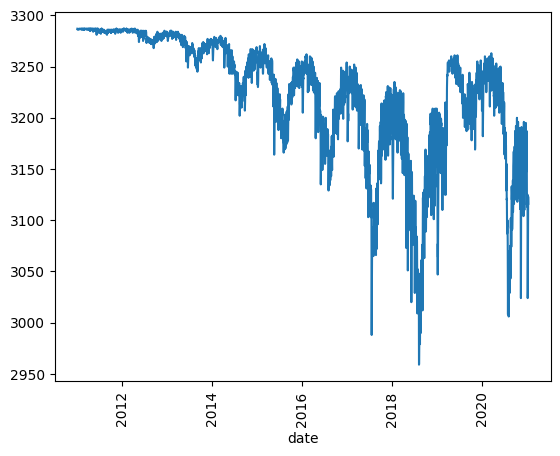

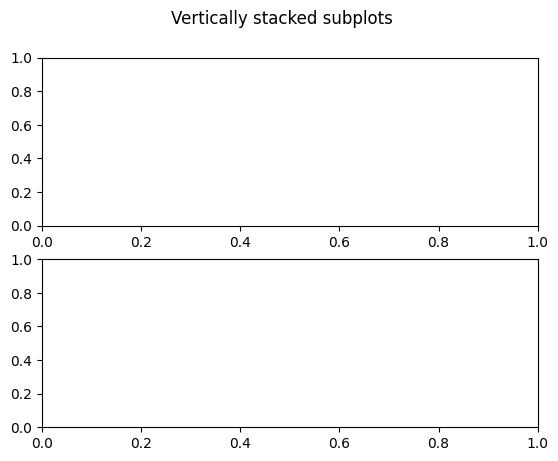

In [10]:
smallListing = '../../data/Stockholm/SmalListings.csv'
reviews = '../../data/Stockholm/reviews.csv'
outPath = '../../data/Stockholm/out/'

a = plotPastAvailability(smallListing, reviews, '2012',outPath+'2021_histogram.svg')
#b = plotPastAvailability(smallListing, reviews, '2022',outPath+'2022.svg')

fig, axs = plt.subplots(2)
fig.suptitle('Vertically stacked subplots')
axs[0].plot(a)
axs[1].plot(b)